In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customers with aggregated transaction data
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total spending
    'Quantity': 'sum',           # Total quantity purchased
    'ProductID': 'nunique'       # Product diversity
}).reset_index()

# Merge with customer profiles
data = customers.merge(transaction_summary, on='CustomerID', how='left')

# Handle missing values (if any)
data.fillna(0, inplace=True)


In [3]:
# One-hot encode categorical variables (e.g., Region)
encoder = OneHotEncoder()
region_encoded = pd.DataFrame(
    encoder.fit_transform(data[['Region']]).toarray(),
    columns=encoder.get_feature_names_out(['Region'])
)

# Add encoded features to dataset
data = pd.concat([data, region_encoded], axis=1)
data.drop(columns=['Region', 'CustomerName', 'SignupDate'], inplace=True)  # Drop unnecessary columns

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'ProductID']
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [4]:
# Select features for clustering
features = data.drop(columns=['CustomerID'])

# Test different numbers of clusters (2 to 10)
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)
    db_index = davies_bouldin_score(features, clusters)
    silhouette = silhouette_score(features, clusters)
    inertia = kmeans.inertia_
    results.append({'k': k, 'DB Index': db_index, 'Silhouette Score': silhouette, 'Inertia': inertia})

# Create a DataFrame for evaluation results
results_df = pd.DataFrame(results)
print(results_df)

# Choose the optimal number of clusters (e.g., lowest DB Index)
optimal_k = results_df.loc[results_df['DB Index'].idxmin(), 'k']

# Final clustering with optimal k
final_kmeans = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
data['Cluster'] = final_kmeans.fit_predict(features)


    k  DB Index  Silhouette Score     Inertia
0   2  0.998638          0.376861  397.811951
1   3  1.201394          0.270070  304.510921
2   4  1.373650          0.220390  264.386845
3   5  1.318902          0.236371  239.719192
4   6  1.288952          0.265097  215.304685
5   7  1.261475          0.282864  194.861810
6   8  1.089917          0.313757  176.427335
7   9  1.036701          0.329665  160.812274
8  10  0.978712          0.347499  143.300852


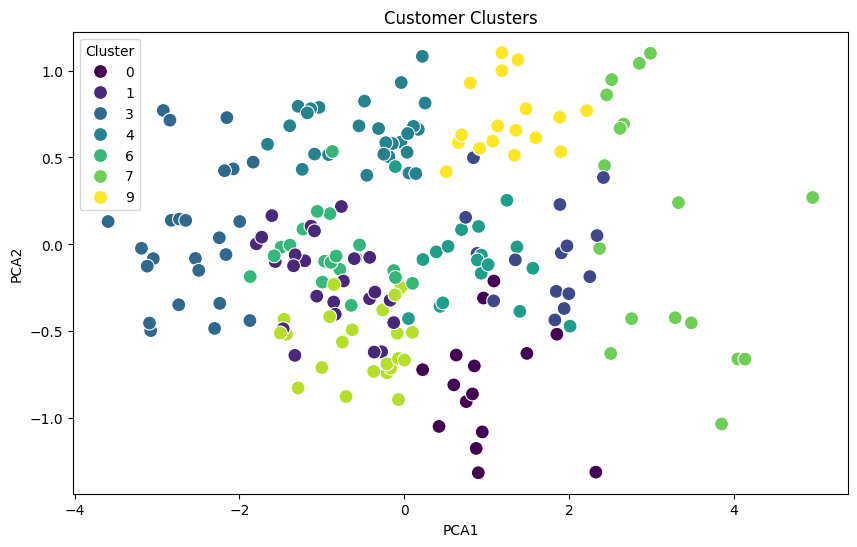

In [5]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(features)
data['PCA1'] = data_2d[:, 0]
data['PCA2'] = data_2d[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [6]:
# Final DB Index and other metrics
final_db_index = davies_bouldin_score(features, data['Cluster'])
final_silhouette = silhouette_score(features, data['Cluster'])

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {final_db_index:.2f}")
print(f"Silhouette Score: {final_silhouette:.2f}")


Optimal Number of Clusters: 10
Davies-Bouldin Index: 0.98
Silhouette Score: 0.35
